In [130]:
import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt  
import seaborn as sns  
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn import metrics
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [5]:
train = pd.read_csv("train_LZdllcl.csv")
test = pd.read_csv("test_2umaH9m.csv")
submission = pd.read_csv("sample_submission_M0L0uXE.csv")

In [6]:
train.head(2)

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0


In [7]:
submission.head(2)

,employee_id,is_promoted
0,8724,0
1,74430,0


In [8]:
train.shape

(54808, 14)

In [9]:
na_columns = train.columns[train.isna().any()]

In [10]:
train[na_columns].isna().sum()/train.shape[0]*100

education               4.395344
previous_year_rating    7.524449
dtype: float64

In [11]:
train.duplicated().sum()

np.int64(0)

In [12]:
train['is_promoted'].value_counts()

is_promoted
0    50140
1     4668
Name: count, dtype: int64

In [13]:
target_column = ['is_promoted']
ignore_column = ['employee_id']

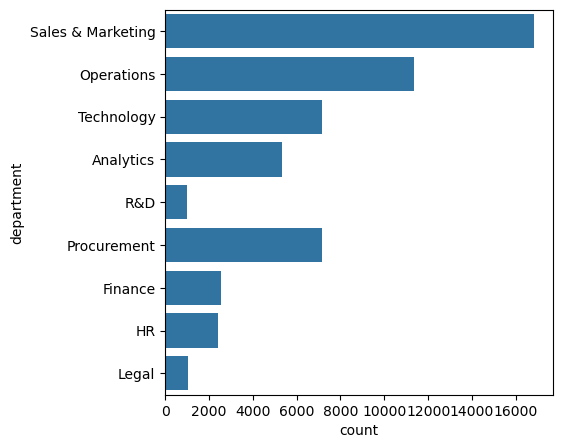

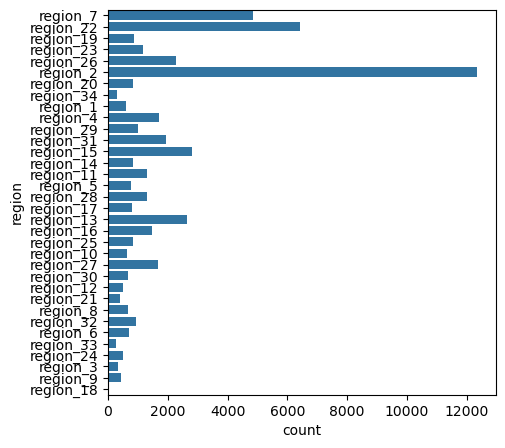

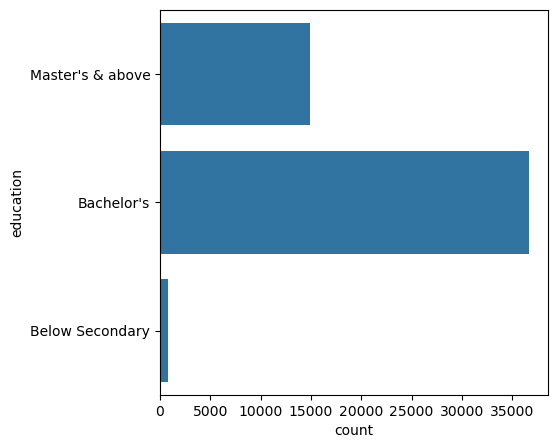

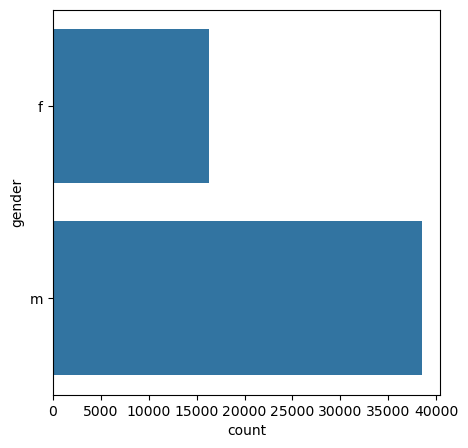

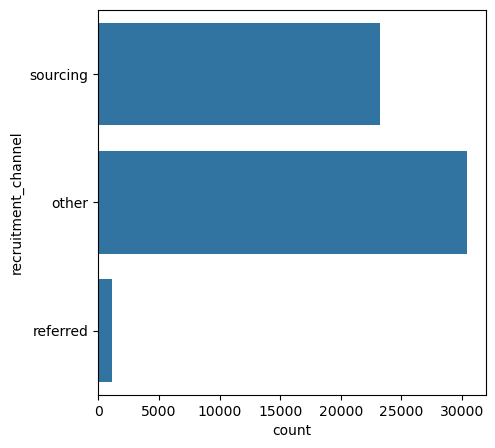

In [14]:
for col in train.select_dtypes(include='object').columns:
  plt.figure(figsize=(5,5))
  sns.countplot(train[col])
  plt.show()

In [15]:
cat_cols = train.select_dtypes(include='object').columns
cat_cols

Index(['department', 'region', 'education', 'gender', 'recruitment_channel'], dtype='object')

In [16]:
num_cols = train.drop(columns=ignore_column+target_column).select_dtypes(exclude='object').columns
num_cols

Index(['no_of_trainings', 'age', 'previous_year_rating', 'length_of_service',
       'KPIs_met >80%', 'awards_won?', 'avg_training_score'],
      dtype='object')

In [17]:
cat_enc = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [18]:
num_enc = Pipeline(steps =[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

In [19]:
preprocess = ColumnTransformer(transformers = [
    ('cat', cat_enc, cat_cols),
    ('num', num_enc, num_cols)
])

In [140]:
model_pipeline = Pipeline(steps=[
    ('preprocess', preprocess),
    ('model', LogisticRegression())
])

In [132]:
X = train.drop(columns=ignore_column+target_column)
y = train['is_promoted']

In [133]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.1, random_state=42)
train_X.shape, test_X.shape, train_y.shape, test_y.shape

((49327, 12), (5481, 12), (49327,), (5481,))

In [141]:
model_pipeline.fit(train_X, train_y)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['department', 'region', 'education', 'gender', 'recruitment_channel'], dtype='object')),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['no_of_trainings', 'age', 'previous_year_rating', 'length_of_service',
       'KPIs_met >80%', 'awards_won?', 'avg_training_score'],
      dtype='object'))])),
                ('model', LogisticRegression())])

In [142]:
model_pipeline.predict(test_X)

array([0, 0, 0, ..., 0, 0, 0])

In [136]:
def model_train_cal_eval(train_X, train_y, test_X, test_y, model_pipeline):
  model_pipeline.fit(train_X, train_y)
  predicted_train_tgt = model_pipeline.predict(train_X)
  predicted_val_tgt = model_pipeline.predict(test_X)

  print('Train Score:',f1_score(train_y, predicted_train_tgt))
  print('Val Score:',f1_score(test_y, predicted_val_tgt))

In [143]:
model_train_cal_eval(train_X, train_y, test_X, test_y, model_pipeline)

Train Score: 0.39628704034273476
Val Score: 0.40418118466898956


In [51]:
submission['is_promoted'] = model_pipeline.predict(test.drop(columns=ignore_column))
submission.to_csv('sub1_logreg_imb.csv',index=False)

In [118]:
param_1 = [
    {
        'model' : [LogisticRegression()],
        'model__penalty' : ['l2',None, 'l1','elasticnet'],
        'model__C' : [0.5, 3]
    },
    {
        'model' : [DecisionTreeClassifier()],
        'model__max_depth' : [3,5]
    },
    {
        'model' : [RandomForestClassifier()],
        'model__n_estimators': [100],
        'model__max_depth': [10, None],
        'model__min_samples_split': [2, 5],
        'model__max_features': ['sqrt'],
        'model__class_weight': ['balanced']
    },
    {
        'model' : [AdaBoostClassifier()],
        'model__n_estimators': [50, 100, 200],
        'model__learning_rate': [0.01, 0.1, 0.5]
    },
    {
        'model' : [GradientBoostingClassifier()],
        'model__n_estimators': [100, 200],
        'model__learning_rate': [0.05, 0.1],
        'model__max_depth': [3, 5],
        'model__subsample': [0.8, 1.0]
    }
]

In [119]:
grid_1 = GridSearchCV(estimator=model_pipeline, param_grid=param_1, cv=2,scoring='f1')

In [120]:
from imblearn.over_sampling import RandomOverSampler

In [121]:
over_sampling = RandomOverSampler(random_state=42)

In [122]:
train_X_os, train_y_os = over_sampling.fit_resample(train_X, train_y)

In [123]:
train_y_os.value_counts()

is_promoted
0    45090
1    45090
Name: count, dtype: int64

In [124]:
grid_1.fit(train_X_os, train_y_os)

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
8 fits failed out of a total of 78.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         Index(['department', 'region', 'education', 'gender', 'recruitment_channel'], dtype='object')),
                                                                        ('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImp...
                          'model__max_features': ['sqrt'],
                          'model__min_samples_split': [2, 5],
                          'model__n_estimators': [100]},
                         {'model': [AdaBoostClassifier()],
                          'model__learning_rate': [0.01, 0.1, 0.5],
                          'model__n_estimators': [50, 100, 200]},
                         {'model': [GradientBoostingClassifier()],
                          'model__learning_rate': [0.05, 0.1],
                          'model__max_depth': [3, 5],
                          'model__n_estimators': [100, 200],
                          'model__subsample': [0.8, 1.0]}],
             scoring='f1')

In [144]:
grid_1.best_params_

{'model': RandomForestClassifier(),
 'model__class_weight': 'balanced',
 'model__max_depth': None,
 'model__max_features': 'sqrt',
 'model__min_samples_split': 2,
 'model__n_estimators': 100}

In [145]:
grid_1.best_estimator_

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['department', 'region', 'education', 'gender', 'recruitment_channel'], dtype='object')),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['no_of_trainings', 'age', 'previous_year_rating', 'length_of_service',
       'KPIs_met >80%', 'awards_won?', 'avg_training_score'],
      dtype='object'))])),
                ('model', RandomForestClassifier(class_weight='balanced'))])

In [146]:
new_model = grid_1.best_estimator_

In [147]:
model_train_cal_eval(train_X_os, train_y_os, test_X, test_y, new_model)

Train Score: 0.9998558646458151
Val Score: 0.4667609618104668


In [129]:
submission['is_promoted'] = new_model.predict(test.drop(columns=ignore_column))
submission.to_csv('sub2_grid_os_rfc.csv',index=False)

In [148]:
import joblib

In [149]:
joblib.dump(new_model,'rfc_pipeline_model.pkl')

['rfc_pipeline_model.pkl']

In [152]:
!pip install streamlit

Access is denied.


In [153]:
pip install streamlit

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [154]:
train.columns

Index(['employee_id', 'department', 'region', 'education', 'gender',
       'recruitment_channel', 'no_of_trainings', 'age', 'previous_year_rating',
       'length_of_service', 'KPIs_met >80%', 'awards_won?',
       'avg_training_score', 'is_promoted'],
      dtype='object')

In [172]:
train.dtypes

employee_id               int64
department               object
region                   object
education                object
gender                   object
recruitment_channel      object
no_of_trainings           int64
age                       int64
previous_year_rating    float64
length_of_service         int64
KPIs_met >80%             int64
awards_won?               int64
avg_training_score        int64
is_promoted               int64
dtype: object

In [171]:
%%writefile app.py
import streamlit as st
import pandas as pd
import joblib

st.title("Employee Promotion Prediction")
st.write("testing..")

df = pd.read_csv("train_LZdllcl.csv")

department = st.selectbox("department", df["department"].unique())
region = st.selectbox("region", df["region"].unique())
education = st.selectbox("education", df["education"].unique())
gender = st.selectbox("gender", df["gender"].unique())
recruitment_channel = st.selectbox(
    "recruitment_channel", df["recruitment_channel"].unique()
)

no_of_trainings = st.number_input("no_of_trainings", min_value=0, step=1)
age = st.number_input("age", min_value=18)
previous_year_rating = st.number_input("previous_year_rating", min_value=0, max_value=5)
length_of_service = st.number_input("length_of_service", min_value=0)
KPIs_met_80 = st.number_input("KPIs_met >80%", min_value=0, max_value=1)
awards_won = st.number_input("awards_won?", min_value=0, max_value=1)
avg_training_score = st.number_input("avg_training_score", min_value=0)

inputs = {
    "department": department,
    "region": region,
    "education": education,
    "gender": gender,
    "recruitment_channel": recruitment_channel,
    "no_of_trainings": no_of_trainings,
    "age": age,
    "previous_year_rating": previous_year_rating,
    "length_of_service": length_of_service,
    "KPIs_met >80%": KPIs_met_80,
    "awards_won?": awards_won,
    "avg_training_score": avg_training_score
}

if st.button("Predict"):
    model = joblib.load("rfc_pipeline_model.pkl")
    X_input = pd.DataFrame([inputs])
    prediction = model.predict(X_input)

    if prediction[0] == 1:
        st.success("🎉 Employee WILL be promoted")
    else:
        st.error("❌ Employee will NOT be promoted")


Overwriting app.py


In [196]:
%%writefile applicationapi.py

from fastapi import FastAPI
from pydantic import BaseModel
import joblib
import pandas as pd

app = FastAPI()

# Load model ONCE
model = joblib.load("rfc_pipeline_model.pkl")

class Input(BaseModel):
    department: str
    region: str
    education: str
    gender: str
    recruitment_channel: str
    no_of_trainings: int
    age: int
    previous_year_rating: float
    length_of_service: int
    KPIs_met_80: int
    awards_won: int
    avg_training_score: int

class Output(BaseModel):
    is_promoted: int

@app.get("/")
def read_root():
    return {"message": "Employee Promotion Prediction API is running"}

@app.post("/predict", response_model=Output)
def predict(data: Input):

    X_input = pd.DataFrame([{
        "department": data.department,
        "region": data.region,
        "education": data.education,
        "gender": data.gender,
        "recruitment_channel": data.recruitment_channel,
        "no_of_trainings": data.no_of_trainings,
        "age": data.age,
        "previous_year_rating": data.previous_year_rating,
        "length_of_service": data.length_of_service,
        "KPIs_met >80%": data.KPIs_met_80,
        "awards_won?": data.awards_won,
        "avg_training_score": data.avg_training_score
    }])

    prediction = model.predict(X_input)

    return {"is_promoted": int(prediction[0])}


Overwriting applicationapi.py


In [197]:
!curl -X GET "http://0.0.0.0:8000/"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
curl: (7) Failed to connect to 0.0.0.0 port 8000 after 0 ms: Could not connect to server


In [175]:
pip install fastapi uvicorn

Defaulting to user installation because normal site-packages is not writeable

   -------------------- ------------------- 2/4 [starlette]
   ------------------------------ --------- 3/4 [fastapi]
   ---------------------------------------- 4/4 [fastapi]

Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [176]:
pip install uvicorn


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [182]:
import streamlit
streamlit.__version__

'1.45.1'

In [183]:
import numpy
numpy.__version__

'2.1.3'

In [184]:
import pandas
pandas.__version__

'2.2.3'

In [185]:
import joblib
joblib.__version__

'1.4.2'

In [186]:
import sklearn
sklearn.__version__

'1.6.1'